# <center>ECE 542 Final Project</center>

## <center>Exploring Vision-Based Models for Land-Usage Classification Using Remote Sensing Imagery Data</center>

### <center> Presented By - Group 163</center>

<center>Anirudh Kaluri (akaluri)</center>

<center>Rishi Singhal (rsingha4)</center>

<center>Yazhuo Gao (ygao46)</center>

### Motivation - Why Land Use Classification?

● Understanding land-use patterns is crucial for sustainable resource management, urban planning, and environmental conservation.

● When combined with deep learning, these images offer insights for disaster recovery, resource allocation, precision agriculture, biodiversity monitoring, and infrastructure planning. A core challenge is accurately classifying land-use patterns from satellite imagery.

### Problem Statement
● Enhance the understanding of deep learning (DL) models' usefulness for land-use classification using three vision-based neural networks to classify remote sensing images.

### Dataset Used
● To explore the task of land-use classification, we use the UC-Merced Land-Use Dataset available at Kaggle [1]. 

● It contains satellite images of different urban regions in the US extracted from USGS National Map Urban Area Imagery collection.

### Input & Output of the Task

● Input:

A RGB satellite image representing a region of land use, e.g., a forest.

● Output:

A predicted class label (e.g., forest, river) corresponding to the land-use image feeded to the network.

### Prior Work

● Rishi has previously worked with vision based models for different classification tasks.

## Import libraries to be Used

In [1]:
## Standard libraries
import os
import sys
import json
import math
import random
import numpy as np 
import subprocess
import copy
import time

## Imports for plotting
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_theme()
from PIL import Image

## Progress bar
from tqdm.notebook import tqdm

## typing
from typing import (
    Any,
    Callable,
    Dict,
    List,
    Optional,
    Sequence,
    Set,
    Tuple,
    Type,
    Union,
)

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## PyTorch Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: 
    !pip install --quiet pytorch-lightning>=1.6
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

## sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Install additional packages
!pip install mmengine
!pip install kaggle
!pip install kagglehub
!pip install torchsummary
!pip install transformers 

### Identify the system

In [3]:
import platform
from mmengine.utils.dl_utils import collect_env
from pprint import pprint

print("=" * 40, "System Information", "=" * 40)
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Node Name: {uname.node}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")
print(f"Processor: {uname.processor}")

print("=" * 40, "Environment Information", "=" * 40)
my_env = collect_env()
pprint(my_env)

======================================== System Information ========================================
System: Linux
Node Name: jupyter-rishi2019194
Release: 5.15.0-119-generic
Version: #129-Ubuntu SMP Fri Aug 2 19:25:20 UTC 2024
Machine: x86_64
Processor: x86_64
======================================== Environment Information ========================================
OrderedDict([('sys.platform', 'linux'),
             ('Python',
              '3.11.8 | packaged by conda-forge | (main, Feb 16 2024, '
              '20:53:32) [GCC 12.3.0]'),
             ('CUDA available', True),
             ('MUSA available', False),
             ('numpy_random_seed', 2147483648),
             ('GPU 0', 'NVIDIA A100-SXM4-40GB'),
             ('CUDA_HOME', None),
             ('GCC', 'gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0'),
             ('PyTorch', '2.2.0+cu121'),
             ('PyTorch compiling details',
              'PyTorch built with:\n'
              '  - GCC 9.3\n'
              '  - C++ Ver

In [4]:
# Setting the seed
pl.seed_everything(42)

NUM_WORKERS = os.cpu_count()
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = True

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Seed set to 42


Device: cuda:0
Number of workers: 32


## Prepare Datasets

In [5]:
# Path to the folder where the datasets are/should be downloaded 
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./checkpoint/ece542_final_proj"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [6]:
# # Download dataset (need username and key to login)
# os.environ['KAGGLE_USERNAME'] = "yazhuog"  # User name
# os.environ['KAGGLE_KEY'] = "04b3533417b01ece0557f2e5f21a4477"  # Password or API token

# import kaggle
# kaggle.api.dataset_download_files("abdulhasibuddin/uc-merced-land-use-dataset", path=DATASET_PATH, unzip=True)

In [7]:
# Download dataset without login
import kagglehub

# Download latest version
DATASET_PATH = kagglehub.dataset_download("abdulhasibuddin/uc-merced-land-use-dataset")

print("Path to dataset files:", DATASET_PATH)

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/abdulhasibuddin/uc-merced-land-use-dataset/versions/1


Now we have the local address to access dataset. Let's load these data and store them into variables.

In [8]:
classname = os.listdir(f"{DATASET_PATH}/UCMerced_LandUse/Images")
path_to_image = f"{DATASET_PATH}/UCMerced_LandUse/Images"
img_paths = []
classes_img = []
for cls in classname:
    path_to_cls_img = os.listdir(f"{DATASET_PATH}/UCMerced_LandUse/Images/{cls}")
    for sub in path_to_cls_img:
        img_paths.append(f"{DATASET_PATH}/UCMerced_LandUse/Images/{cls}/{sub}")
        classes_img.append(cls)

In [9]:
img_paths[0],classes_img[0]

('/home/jovyan/.cache/kagglehub/datasets/abdulhasibuddin/uc-merced-land-use-dataset/versions/1/UCMerced_LandUse/Images/parkinglot/parkinglot39.tif',
 'parkinglot')

### Defining Pipeline for image

It would be nice to use data augmentation for our dataset to make our model more generative.
Accordingly select approaches to modify input data.

In [10]:
Transform_pipeline = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally with 50% probability (74%)
    transforms.RandomRotation(degrees=30),  # Rotate images randomly within ±30 degrees (74%)
    # transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),  # Crop images randomly (68%)
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc. (65%)
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Apply random translation (72%)
    # transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Apply random perspective transformations (69%)
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

### Loading DataLoader and Custom Data Set

In [11]:
class Dataset_class(data.Dataset):
    def __init__(self,paths,labels,transform):
        super().__init__()
        self.paths = paths
        self.transform=transform
        self.labels = labels
        self.length = labels.shape[0]
        
    def __len__(self):
        return self.length
    
    def __getitem__(self,idx):
        # print("This is getitem idx :",idx,type(idx))
        img_path = self.paths[idx]
        img = Image.open(img_path)
        img = self.transform(img)
        # print(type(img),img.shape)
        label = self.labels[idx]
        return img,label

To understand our dataset, let's print class information with respect to images.

In [12]:
# Label image categories
img_category = np.unique(classes_img)
labelencode = LabelEncoder()
labels = labelencode.fit_transform(classes_img)
label_category = np.unique(labels)

In [13]:
print("=" * 10, "Image Categories", "=" * 10)
for i in range(len(np.unique(labels))):
    print(f"{label_category[i]}: {img_category[i]}")

========== Image Categories ==========
0: agricultural
1: airplane
2: baseballdiamond
3: beach
4: buildings
5: chaparral
6: denseresidential
7: forest
8: freeway
9: golfcourse
10: harbor
11: intersection
12: mediumresidential
13: mobilehomepark
14: overpass
15: parkinglot
16: river
17: runway
18: sparseresidential
19: storagetanks
20: tenniscourt


Before going to model architecture, we should construct our train and validation dataset. Here we split them as train set (75%) and validation set (25%) to make sure balance. 

For data loaders, we apply a batch size of 16 for mini batches. RAM distributor is also activated and splitted to accelerate our training process.

In [14]:
x_train,x_val,y_train,y_val = train_test_split(img_paths,labels,test_size = 0.3,random_state = 42)
x_val,x_test,y_val,y_test = train_test_split(x_val, y_val, test_size = 0.5, random_state = 42)

train_dataset = Dataset_class(x_train,y_train,Transform_pipeline)
val_dataset = Dataset_class(x_val,y_val,Transform_pipeline)
test_dataset = Dataset_class(x_test,y_test,Transform_pipeline)

batch_size = 16

train_loader= data.DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers=int(NUM_WORKERS*0.75), 
    pin_memory=True,
    persistent_workers=True
)

val_loader = data.DataLoader(
    dataset = val_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers=int(NUM_WORKERS*0.25), 
    pin_memory=True,
    persistent_workers=True
)

test_loader = data.DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers=int(NUM_WORKERS*0.25), 
    pin_memory=True,
    persistent_workers=True
)

## Train with Customized mode

Next is the procedure to train our model. We'll treat learning rate as hyperparameter and plug it in both Adam and SGD optimizer to compare performance.

In [15]:
def train_one_epoch(model, loss_module, optimizer, data_loader, loop):
    model.train()
    true_preds, total_loss = 0, 0.0
    total_samples = 0

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        # print(imgs.size())

        pred = model(imgs, return_dict=True).logits
        loss = loss_module(pred, labels)
        total_loss += loss.item() * imgs.size(0)
        true_preds += (torch.argmax(pred, dim=1) == labels).sum().item()
        total_samples += imgs.size(0)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss = total_loss / total_samples
        running_acc = true_preds / total_samples

        # Update tqdm progress
        loop.set_postfix(train_loss=round(running_loss, 4), train_acc=f"{round(running_acc*100, 2)}%")

    epoch_loss = total_loss / total_samples
    epoch_acc = true_preds / total_samples
    return epoch_loss, epoch_acc


In [16]:
@torch.no_grad()
def test_model(model, loss_module, data_loader, loop):
    model.eval()  # Set model to evaluation mode
    true_preds, total_samples = 0.0, 0
    total_loss = 0.0

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs, return_dict=True).logits
        loss = loss_module(outputs, labels)  # Compute loss
        total_loss += loss.item() * labels.size(0)  # Sum loss over batch
        preds = outputs.argmax(dim=1) 

        true_preds += (preds == labels).sum().item()  
        total_samples += labels.size(0)  

        running_loss = total_loss / total_samples
        running_acc = true_preds / total_samples

        # Update tqdm progress
        loop.set_postfix(val_loss=round(running_loss, 4), val_acc=f"{round(running_acc*100, 2)}%")

    accuracy = true_preds / total_samples  # Compute accuracy percentage
    val_loss = total_loss / total_samples  # Average loss per sample
    return accuracy, val_loss

In [17]:
def save_model(model, model_name, root_dir=CHECKPOINT_PATH):
    os.makedirs(root_dir, exist_ok=True)  # Ensure the directory exists
    model_path = os.path.join(root_dir, f"{model_name}.pt")
    
    torch.save(model.state_dict(), model_path)
    print(f"Best model saved to {model_path}")

def load_model(model, model_name, root_dir=CHECKPOINT_PATH):
    model_path = os.path.join(root_dir, f"{model_name}.pt")
    
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"No checkpoint found at {model_path}")
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    print(f"Best model loaded from {model_path}")
    return model

In [18]:
def evaluate(model):
    model.eval()

    # Collect predictions and true labels from validation set
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs, return_dict=True).logits
            preds = torch.argmax(outputs, dim=1)
    
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    print("\n=== Final Evaluation on Best Model ===")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print("=====================================\n")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    labels = sorted(set(all_labels))
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix (Validation Set)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

In [19]:
def train_model(model, optimizer, loss_module, train_data_loader, val_data_loader, num_epochs=25, model_name="MyModel"):
    model.to(device)
    best_val_acc = -1.0
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(1, num_epochs + 1):
        # Create tqdm progress bar here and pass it to train_one_epoch
        train_loop = tqdm(train_data_loader,  leave=False, desc=f"Epoch {epoch}/{num_epochs} ")
        train_loss, train_acc = train_one_epoch(model, loss_module, optimizer, train_data_loader, train_loop)

        print_data = 0
        val_loop = tqdm(val_data_loader, leave=False, desc=f"Validating Epoch {epoch} ")
        acc, loss = test_model(model, loss_module, val_data_loader, val_loop)
        
        # Save model when a higher accuracy found
        if acc > best_val_acc:
            best_val_acc = acc
            save_model(model, model_name, CHECKPOINT_PATH)
            print_data = 1

        if print_data or epoch % 10 == 0 or epoch == num_epochs:
            print(
                f"[Epoch {epoch:2d}] Training loss: {train_loss:05.3f}, Training accuracy: {train_acc*100.0:05.2f}%, Validation loss: {loss:05.3f}, Validation accuracy: {acc*100.0:05.2f}%, Best validation accuracy: {best_val_acc*100.0:05.2f}%"
            )
            print("--------------------------------------------------")

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(loss)
        val_accs.append(acc)

    model = load_model(model, model_name, CHECKPOINT_PATH)
    return model, train_losses, train_accs, val_losses, val_accs


In [20]:
# Calculate size of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters()) / 1e6

### Loading and Training DeiT (Unfreezing all layers)

In [21]:
### Loading DeiT transformer
from transformers import DeiTForImageClassification
import torch.nn as nn
import torch
# Load model
model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", num_labels = len(classname))

# Start training the model
loss_module_SGD=nn.CrossEntropyLoss()
optimizer_SGD=torch.optim.SGD(params=model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
num_epochs_SGD=50

# print(f"model DeiT created: {count_parameters(model):05.3f}M")
train_start_SGD = time.time()
model, train_losses_SGD, train_accs_SGD, val_losses_SGD, val_accs_SGD=train_model(model, optimizer_SGD, loss_module_SGD, train_loader, val_loader, num_epochs_SGD, model_name="DeiT_SGD")
train_end_SGD = time.time()

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 1 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  1] Training loss: 1.235, Training accuracy: 69.05%, Validation loss: 0.285, Validation accuracy: 94.29%, Best validation accuracy: 94.29%
--------------------------------------------------


Epoch 2/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 2 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  2] Training loss: 0.145, Training accuracy: 96.53%, Validation loss: 0.144, Validation accuracy: 97.46%, Best validation accuracy: 97.46%
--------------------------------------------------


Epoch 3/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 3 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 4 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 5 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 6 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  6] Training loss: 0.018, Training accuracy: 99.86%, Validation loss: 0.082, Validation accuracy: 98.10%, Best validation accuracy: 98.10%
--------------------------------------------------


Epoch 7/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 7 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 8 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 9 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 10 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 10] Training loss: 0.008, Training accuracy: 100.00%, Validation loss: 0.059, Validation accuracy: 97.46%, Best validation accuracy: 98.10%
--------------------------------------------------


Epoch 11/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 11 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 12 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch 12] Training loss: 0.006, Training accuracy: 100.00%, Validation loss: 0.057, Validation accuracy: 98.73%, Best validation accuracy: 98.73%
--------------------------------------------------


Epoch 13/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 13 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 14 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 15 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 16 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 17 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 18 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 19 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 20 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 20] Training loss: 0.003, Training accuracy: 100.00%, Validation loss: 0.060, Validation accuracy: 98.10%, Best validation accuracy: 98.73%
--------------------------------------------------


Epoch 21/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 21 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 22 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 23 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 24 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 25 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 26 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 27 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 28 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 29 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 30 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 30] Training loss: 0.002, Training accuracy: 100.00%, Validation loss: 0.053, Validation accuracy: 97.78%, Best validation accuracy: 98.73%
--------------------------------------------------


Epoch 31/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 31 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 32 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 33 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 34 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch 34] Training loss: 0.002, Training accuracy: 100.00%, Validation loss: 0.042, Validation accuracy: 99.05%, Best validation accuracy: 99.05%
--------------------------------------------------


Epoch 35/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 35 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 36 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 37 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 38 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 39 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 40 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 40] Training loss: 0.001, Training accuracy: 100.00%, Validation loss: 0.064, Validation accuracy: 98.41%, Best validation accuracy: 99.05%
--------------------------------------------------


Epoch 41/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 41 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 42/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 42 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 43 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 44 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 45 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 46 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 47 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 48 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 49 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 50 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 50] Training loss: 0.001, Training accuracy: 100.00%, Validation loss: 0.059, Validation accuracy: 98.10%, Best validation accuracy: 99.05%
--------------------------------------------------
Best model loaded from ./checkpoint/ece542_final_proj/DeiT_SGD.pt


Training spent: 9min 43.23sec

=== Final Evaluation on Best Model ===
Accuracy:  0.9714
Precision: 0.9759
Recall:    0.9756
F1-score:  0.9747



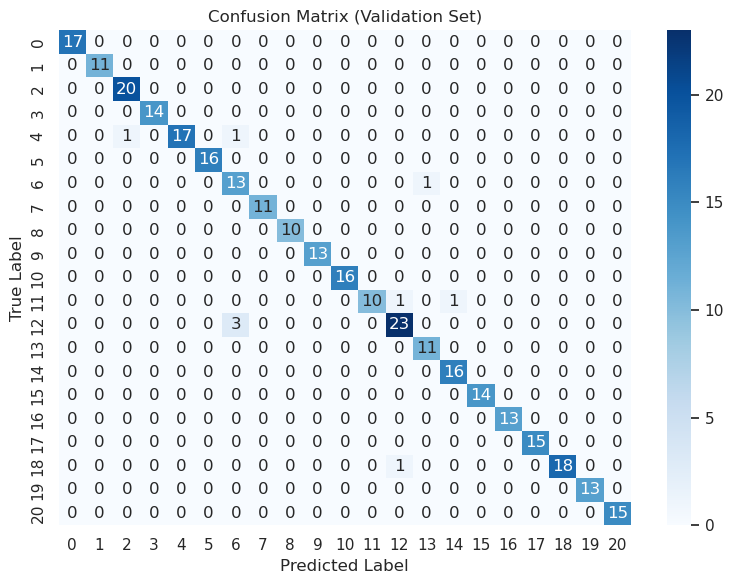

In [22]:
duration_SGD = train_end_SGD-train_start_SGD
minutes_SGD = int(duration_SGD // 60)
seconds_SGD = duration_SGD % 60

if minutes_SGD > 0:
    print(f"Training spent: {minutes_SGD}min {seconds_SGD:.2f}sec")
else:
    print(f"Training spent: {seconds_SGD:.2f}sec")

# evaluate on the test-set
evaluate(model)


In [23]:
# Plot results using curve_fit
from scipy.optimize import curve_fit

def plot_training_curvefit(train_losses, val_losses, train_accs, val_accs):    
    epochs = np.arange(1, len(train_losses) + 1)
    
    # Function to fit polynomial of given degree
    def fit_polynomial(x, y, degree):
        coeffs = np.polyfit(x, y, degree)  # Fit polynomial
        return np.polyval(coeffs, x), coeffs  # Evaluate polynomial
    
    # Choose degree for polynomial fitting
    degree = (len(train_losses) / 10) + 1 
    
    # Fit polynomial curves to the training loss, training accuracy, and validation accuracy
    fitted_loss, coeffs_loss = fit_polynomial(epochs, train_losses, degree)
    fitted_train_acc, coeffs_train_acc = fit_polynomial(epochs, train_accs, degree)
    fitted_val_loss, coeffs_val_loss = fit_polynomial(epochs, val_losses, degree)
    fitted_val_acc, coeffs_val_acc = fit_polynomial(epochs, val_accs, degree)
    
    # Plot comparison
    plt.figure(figsize=(12, 5))
    
    # Plot Fitted Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo', alpha=0.3, label='Original Loss')
    plt.plot(epochs, fitted_loss, 'b-', label='Smoothed Loss', linewidth=2)
    plt.plot(epochs, val_losses, 'ro', alpha=0.3, label='Original Val Loss')
    plt.plot(epochs, fitted_val_loss, 'r-', label='Smoothed Validation Loss', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Curve-Fitted Training & Validation Loss')
    
    # Plot Fitted Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo', alpha=0.3, label='Original Train Acc')
    plt.plot(epochs, fitted_train_acc, 'b-', label='Smoothed Train Acc', linewidth=2)
    plt.plot(epochs, val_accs, 'ro', alpha=0.3, label='Original Val Acc')
    plt.plot(epochs, fitted_val_acc, 'r-', label='Smoothed Val Acc', linewidth=2)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Curve-Fitted Training & Validation Accuracy')
    
    plt.show()

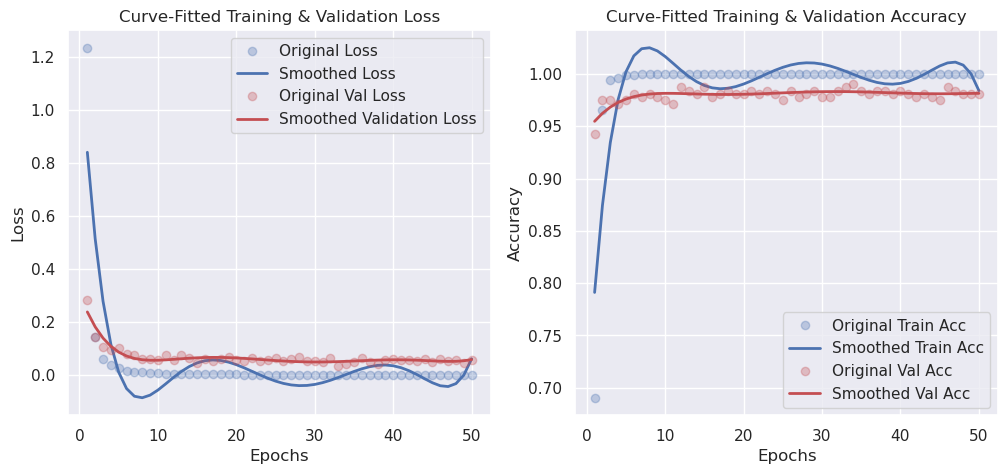

In [24]:
if "train_losses_SGD" in globals():
    plot_training_curvefit(train_losses_SGD, val_losses_SGD, train_accs_SGD, val_accs_SGD)

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable: deit.embeddings.cls_token
Trainable: deit.embeddings.distillation_token
Trainable: deit.embeddings.position_embeddings
Trainable: deit.embeddings.patch_embeddings.projection.weight
Trainable: deit.embeddings.patch_embeddings.projection.bias
Trainable: deit.encoder.layer.3.attention.attention.query.weight
Trainable: deit.encoder.layer.3.attention.attention.query.bias
Trainable: deit.encoder.layer.3.attention.attention.key.weight
Trainable: deit.encoder.layer.3.attention.attention.key.bias
Trainable: deit.encoder.layer.3.attention.attention.value.weight
Trainable: deit.encoder.layer.3.attention.attention.value.bias
Trainable: deit.encoder.layer.3.attention.output.dense.weight
Trainable: deit.encoder.layer.3.attention.output.dense.bias
Trainable: deit.encoder.layer.3.intermediate.dense.weight
Trainable: deit.encoder.layer.3.intermediate.dense.bias
Trainable: deit.encoder.layer.3.output.dense.weight
Trainable: deit.encoder.layer.3.output.dense.bias
Trainable: deit.encoder.layer.

Epoch 1/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 1 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  1] Training loss: 1.320, Training accuracy: 66.05%, Validation loss: 0.267, Validation accuracy: 95.24%, Best validation accuracy: 95.24%
--------------------------------------------------


Epoch 2/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 2 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 3 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  3] Training loss: 0.071, Training accuracy: 99.18%, Validation loss: 0.120, Validation accuracy: 96.83%, Best validation accuracy: 96.83%
--------------------------------------------------


Epoch 4/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 4 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 5 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  5] Training loss: 0.028, Training accuracy: 100.00%, Validation loss: 0.090, Validation accuracy: 97.46%, Best validation accuracy: 97.46%
--------------------------------------------------


Epoch 6/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 6 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 7 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 8 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  8] Training loss: 0.014, Training accuracy: 99.93%, Validation loss: 0.071, Validation accuracy: 97.78%, Best validation accuracy: 97.78%
--------------------------------------------------


Epoch 9/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 9 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 10 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 10] Training loss: 0.009, Training accuracy: 100.00%, Validation loss: 0.078, Validation accuracy: 97.78%, Best validation accuracy: 97.78%
--------------------------------------------------


Epoch 11/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 11 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch 11] Training loss: 0.009, Training accuracy: 100.00%, Validation loss: 0.059, Validation accuracy: 98.41%, Best validation accuracy: 98.41%
--------------------------------------------------


Epoch 12/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 12 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 13 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 14 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 15 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 16 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 17 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch 17] Training loss: 0.004, Training accuracy: 100.00%, Validation loss: 0.044, Validation accuracy: 98.73%, Best validation accuracy: 98.73%
--------------------------------------------------


Epoch 18/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 18 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 19 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 20 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 20] Training loss: 0.004, Training accuracy: 100.00%, Validation loss: 0.059, Validation accuracy: 97.78%, Best validation accuracy: 98.73%
--------------------------------------------------


Epoch 21/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 21 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 22 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 23 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 24 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 25 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 26 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 27 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 28 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 29 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 30 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 30] Training loss: 0.002, Training accuracy: 100.00%, Validation loss: 0.072, Validation accuracy: 96.83%, Best validation accuracy: 98.73%
--------------------------------------------------


Epoch 31/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 31 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 32 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 33 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 34 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 35 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 36 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 37 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 38 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 39 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 40 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 40] Training loss: 0.001, Training accuracy: 100.00%, Validation loss: 0.051, Validation accuracy: 98.73%, Best validation accuracy: 98.73%
--------------------------------------------------


Epoch 41/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 41 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 42/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 42 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 43 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 44 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch 44] Training loss: 0.001, Training accuracy: 100.00%, Validation loss: 0.038, Validation accuracy: 99.05%, Best validation accuracy: 99.05%
--------------------------------------------------


Epoch 45/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 45 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 46 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 47 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 48 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 49 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 50 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 50] Training loss: 0.001, Training accuracy: 100.00%, Validation loss: 0.052, Validation accuracy: 98.41%, Best validation accuracy: 99.05%
--------------------------------------------------
Best model loaded from ./checkpoint/ece542_final_proj/DeiT_SGD.pt
Training spent: 9min 1.78sec

=== Final Evaluation on Best Model ===
Accuracy:  0.9810
Precision: 0.9839
Recall:    0.9834
F1-score:  0.9833



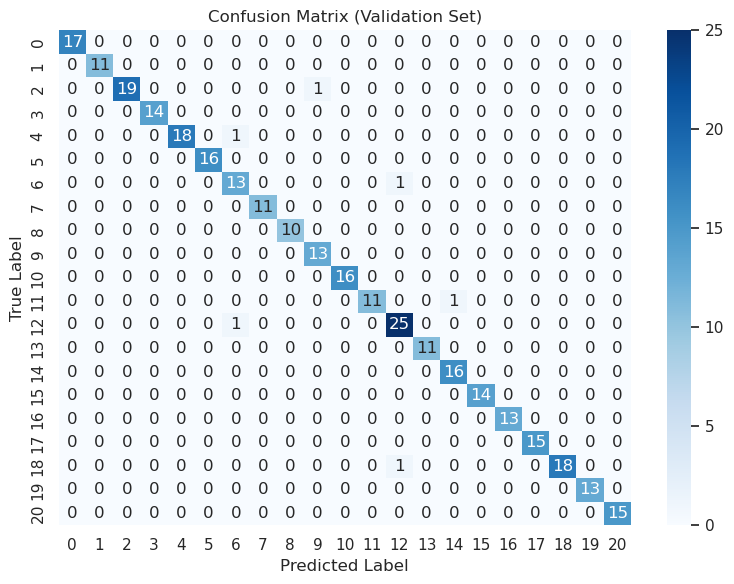

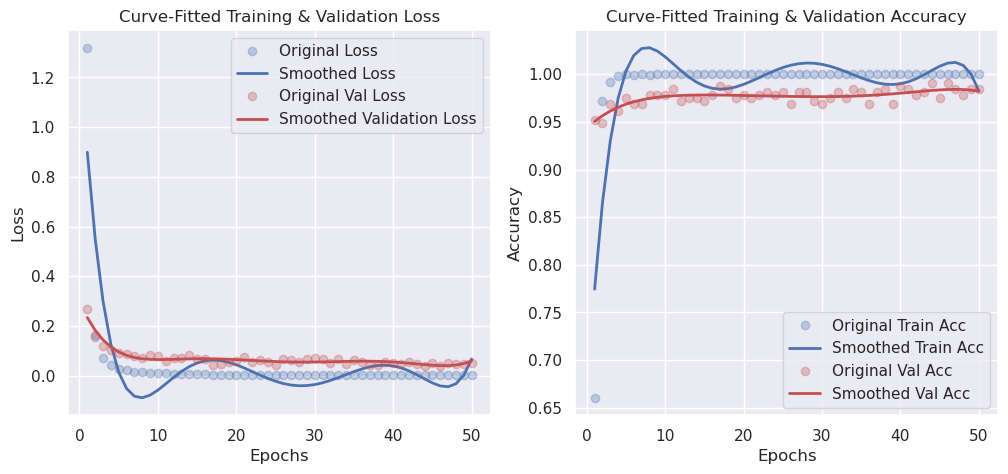

In [25]:
### Loading and Training DeiT (Unfreezing all layers - 1st 3 layers)
### Loading DeiT transformer
# Load model
model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", num_labels = len(classname))
# Freeze first 3 encoder layers
for layer in model.deit.encoder.layer[:3]:
    for param in layer.parameters():
        param.requires_grad = False

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")
        
# Start training the model
loss_module_SGD=nn.CrossEntropyLoss()
optimizer_SGD=torch.optim.SGD(params=model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
num_epochs_SGD=50

# print(f"model DeiT created: {count_parameters(model):05.3f}M")
train_start_SGD = time.time()
model, train_losses_SGD, train_accs_SGD, val_losses_SGD, val_accs_SGD=train_model(model, optimizer_SGD, loss_module_SGD, train_loader, val_loader, num_epochs_SGD, model_name="DeiT_SGD")
train_end_SGD = time.time()

duration_SGD = train_end_SGD-train_start_SGD
minutes_SGD = int(duration_SGD // 60)
seconds_SGD = duration_SGD % 60

if minutes_SGD > 0:
    print(f"Training spent: {minutes_SGD}min {seconds_SGD:.2f}sec")
else:
    print(f"Training spent: {seconds_SGD:.2f}sec")

# evaluate on the test-set
evaluate(model)

if "train_losses_SGD" in globals():
    plot_training_curvefit(train_losses_SGD, val_losses_SGD, train_accs_SGD, val_accs_SGD)


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable: deit.embeddings.cls_token
Trainable: deit.embeddings.distillation_token
Trainable: deit.embeddings.position_embeddings
Trainable: deit.embeddings.patch_embeddings.projection.weight
Trainable: deit.embeddings.patch_embeddings.projection.bias
Trainable: deit.encoder.layer.6.attention.attention.query.weight
Trainable: deit.encoder.layer.6.attention.attention.query.bias
Trainable: deit.encoder.layer.6.attention.attention.key.weight
Trainable: deit.encoder.layer.6.attention.attention.key.bias
Trainable: deit.encoder.layer.6.attention.attention.value.weight
Trainable: deit.encoder.layer.6.attention.attention.value.bias
Trainable: deit.encoder.layer.6.attention.output.dense.weight
Trainable: deit.encoder.layer.6.attention.output.dense.bias
Trainable: deit.encoder.layer.6.intermediate.dense.weight
Trainable: deit.encoder.layer.6.intermediate.dense.bias
Trainable: deit.encoder.layer.6.output.dense.weight
Trainable: deit.encoder.layer.6.output.dense.bias
Trainable: deit.encoder.layer.

Epoch 1/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 1 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  1] Training loss: 1.321, Training accuracy: 66.60%, Validation loss: 0.309, Validation accuracy: 93.97%, Best validation accuracy: 93.97%
--------------------------------------------------


Epoch 2/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 2 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  2] Training loss: 0.169, Training accuracy: 97.21%, Validation loss: 0.159, Validation accuracy: 96.19%, Best validation accuracy: 96.19%
--------------------------------------------------


Epoch 3/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 3 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  3] Training loss: 0.081, Training accuracy: 98.98%, Validation loss: 0.124, Validation accuracy: 96.51%, Best validation accuracy: 96.51%
--------------------------------------------------


Epoch 4/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 4 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  4] Training loss: 0.051, Training accuracy: 99.52%, Validation loss: 0.103, Validation accuracy: 97.46%, Best validation accuracy: 97.46%
--------------------------------------------------


Epoch 5/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 5 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  5] Training loss: 0.031, Training accuracy: 100.00%, Validation loss: 0.090, Validation accuracy: 97.78%, Best validation accuracy: 97.78%
--------------------------------------------------


Epoch 6/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 6 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 7 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 8 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 9 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  9] Training loss: 0.012, Training accuracy: 100.00%, Validation loss: 0.073, Validation accuracy: 98.10%, Best validation accuracy: 98.10%
--------------------------------------------------


Epoch 10/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 10 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 10] Training loss: 0.011, Training accuracy: 100.00%, Validation loss: 0.075, Validation accuracy: 98.10%, Best validation accuracy: 98.10%
--------------------------------------------------


Epoch 11/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 11 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 12 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 13 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 14 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 15 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 16 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 17 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 18 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 19 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 20 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 20] Training loss: 0.004, Training accuracy: 100.00%, Validation loss: 0.065, Validation accuracy: 97.46%, Best validation accuracy: 98.10%
--------------------------------------------------


Epoch 21/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 21 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 22 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 23 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 24 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 25 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch 25] Training loss: 0.003, Training accuracy: 100.00%, Validation loss: 0.042, Validation accuracy: 98.41%, Best validation accuracy: 98.41%
--------------------------------------------------


Epoch 26/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 26 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 27 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 28 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 29 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 30 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 30] Training loss: 0.002, Training accuracy: 100.00%, Validation loss: 0.066, Validation accuracy: 97.46%, Best validation accuracy: 98.41%
--------------------------------------------------


Epoch 31/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 31 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 32 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 33 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 34 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 35 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 36 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 37 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 38 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 39 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 40 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 40] Training loss: 0.002, Training accuracy: 100.00%, Validation loss: 0.066, Validation accuracy: 97.78%, Best validation accuracy: 98.41%
--------------------------------------------------


Epoch 41/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 41 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 42/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 42 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 43 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 44 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 45 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 46 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 47 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 48 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch 48] Training loss: 0.001, Training accuracy: 100.00%, Validation loss: 0.050, Validation accuracy: 98.73%, Best validation accuracy: 98.73%
--------------------------------------------------


Epoch 49/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 49 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 50 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 50] Training loss: 0.001, Training accuracy: 100.00%, Validation loss: 0.050, Validation accuracy: 98.10%, Best validation accuracy: 98.73%
--------------------------------------------------
Best model loaded from ./checkpoint/ece542_final_proj/DeiT_SGD.pt
Training spent: 8min 22.19sec

=== Final Evaluation on Best Model ===
Accuracy:  0.9683
Precision: 0.9696
Recall:    0.9701
F1-score:  0.9694



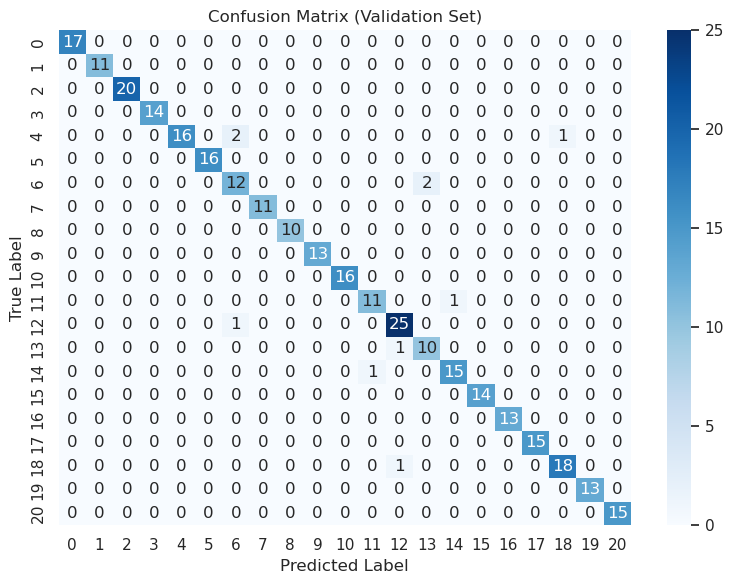

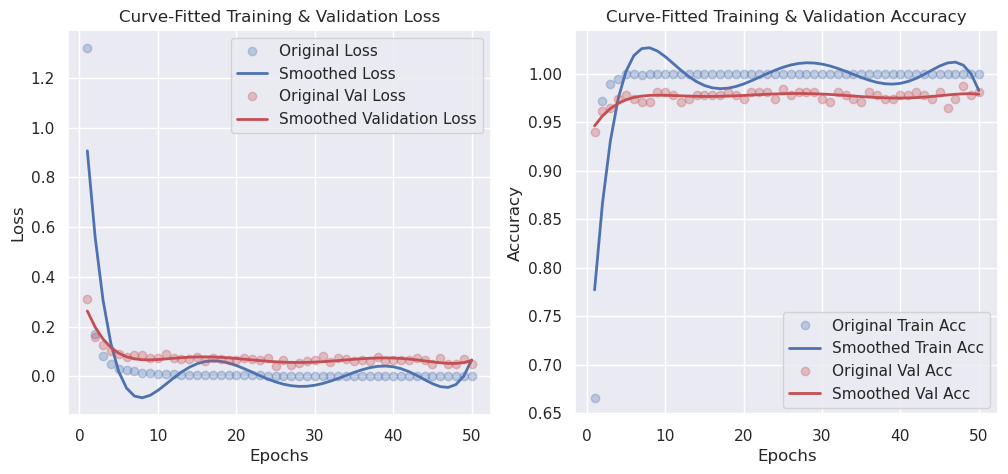

In [26]:
### Loading and Training DeiT (Unfreezing all layers - 1st 6 layers)
### Loading DeiT transformer
# Load model
model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", num_labels = len(classname))

# Freeze first 6 encoder layers
for layer in model.deit.encoder.layer[:6]:
    for param in layer.parameters():
        param.requires_grad = False

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")
        
# Start training the model
loss_module_SGD=nn.CrossEntropyLoss()
optimizer_SGD=torch.optim.SGD(params=model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
num_epochs_SGD=50

# print(f"model DeiT created: {count_parameters(model):05.3f}M")
train_start_SGD = time.time()
model, train_losses_SGD, train_accs_SGD, val_losses_SGD, val_accs_SGD=train_model(model, optimizer_SGD, loss_module_SGD, train_loader, val_loader, num_epochs_SGD, model_name="DeiT_SGD")
train_end_SGD = time.time()

duration_SGD = train_end_SGD-train_start_SGD
minutes_SGD = int(duration_SGD // 60)
seconds_SGD = duration_SGD % 60

if minutes_SGD > 0:
    print(f"Training spent: {minutes_SGD}min {seconds_SGD:.2f}sec")
else:
    print(f"Training spent: {seconds_SGD:.2f}sec")

# evaluate on the test-set
evaluate(model)

if "train_losses_SGD" in globals():
    plot_training_curvefit(train_losses_SGD, val_losses_SGD, train_accs_SGD, val_accs_SGD)

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable: deit.embeddings.cls_token
Trainable: deit.embeddings.distillation_token
Trainable: deit.embeddings.position_embeddings
Trainable: deit.embeddings.patch_embeddings.projection.weight
Trainable: deit.embeddings.patch_embeddings.projection.bias
Trainable: deit.encoder.layer.9.attention.attention.query.weight
Trainable: deit.encoder.layer.9.attention.attention.query.bias
Trainable: deit.encoder.layer.9.attention.attention.key.weight
Trainable: deit.encoder.layer.9.attention.attention.key.bias
Trainable: deit.encoder.layer.9.attention.attention.value.weight
Trainable: deit.encoder.layer.9.attention.attention.value.bias
Trainable: deit.encoder.layer.9.attention.output.dense.weight
Trainable: deit.encoder.layer.9.attention.output.dense.bias
Trainable: deit.encoder.layer.9.intermediate.dense.weight
Trainable: deit.encoder.layer.9.intermediate.dense.bias
Trainable: deit.encoder.layer.9.output.dense.weight
Trainable: deit.encoder.layer.9.output.dense.bias
Trainable: deit.encoder.layer.

Epoch 1/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 1 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  1] Training loss: 1.555, Training accuracy: 61.56%, Validation loss: 0.477, Validation accuracy: 88.89%, Best validation accuracy: 88.89%
--------------------------------------------------


Epoch 2/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 2 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  2] Training loss: 0.263, Training accuracy: 95.24%, Validation loss: 0.251, Validation accuracy: 93.65%, Best validation accuracy: 93.65%
--------------------------------------------------


Epoch 3/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 3 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  3] Training loss: 0.139, Training accuracy: 98.03%, Validation loss: 0.197, Validation accuracy: 96.19%, Best validation accuracy: 96.19%
--------------------------------------------------


Epoch 4/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 4 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 5 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  5] Training loss: 0.065, Training accuracy: 99.39%, Validation loss: 0.148, Validation accuracy: 96.51%, Best validation accuracy: 96.51%
--------------------------------------------------


Epoch 6/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 6 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 7 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 8 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  8] Training loss: 0.032, Training accuracy: 99.93%, Validation loss: 0.097, Validation accuracy: 97.14%, Best validation accuracy: 97.14%
--------------------------------------------------


Epoch 9/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 9 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 10 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 10] Training loss: 0.022, Training accuracy: 100.00%, Validation loss: 0.117, Validation accuracy: 96.51%, Best validation accuracy: 97.14%
--------------------------------------------------


Epoch 11/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 11 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 12 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 13 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 14 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 15 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 16 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 17 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 18 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 19 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 20 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 20] Training loss: 0.009, Training accuracy: 100.00%, Validation loss: 0.096, Validation accuracy: 97.14%, Best validation accuracy: 97.14%
--------------------------------------------------


Epoch 21/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 21 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 22 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 23 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch 23] Training loss: 0.009, Training accuracy: 100.00%, Validation loss: 0.091, Validation accuracy: 98.10%, Best validation accuracy: 98.10%
--------------------------------------------------


Epoch 24/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 24 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 25 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 26 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 27 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 28 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 29 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 30 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 30] Training loss: 0.005, Training accuracy: 100.00%, Validation loss: 0.080, Validation accuracy: 96.83%, Best validation accuracy: 98.10%
--------------------------------------------------


Epoch 31/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 31 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 32 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 33 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 34 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 35 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 36 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 37 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 38 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 39 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 40 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 40] Training loss: 0.004, Training accuracy: 100.00%, Validation loss: 0.073, Validation accuracy: 98.10%, Best validation accuracy: 98.10%
--------------------------------------------------


Epoch 41/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 41 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 42/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 42 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 43 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 44 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 45 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 46 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 47 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 48 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 49 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 50 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 50] Training loss: 0.003, Training accuracy: 100.00%, Validation loss: 0.061, Validation accuracy: 97.78%, Best validation accuracy: 98.10%
--------------------------------------------------
Best model loaded from ./checkpoint/ece542_final_proj/DeiT_SGD.pt
Training spent: 7min 38.48sec

=== Final Evaluation on Best Model ===
Accuracy:  0.9587
Precision: 0.9608
Recall:    0.9599
F1-score:  0.9597



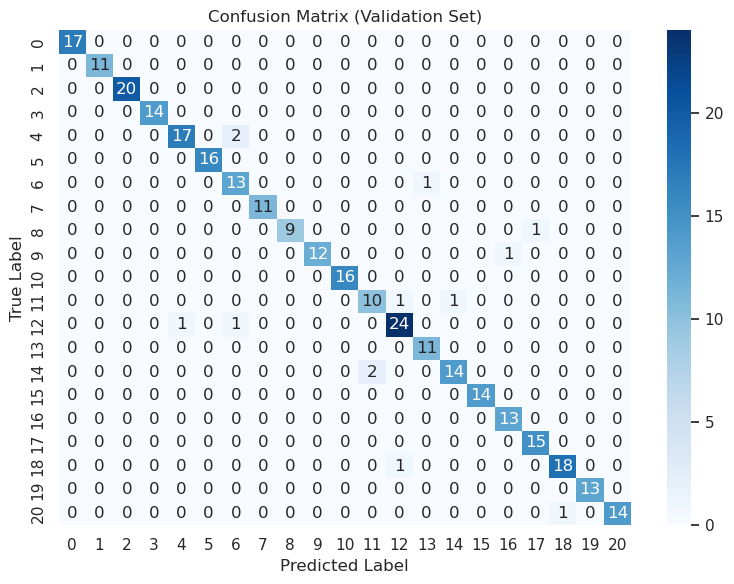

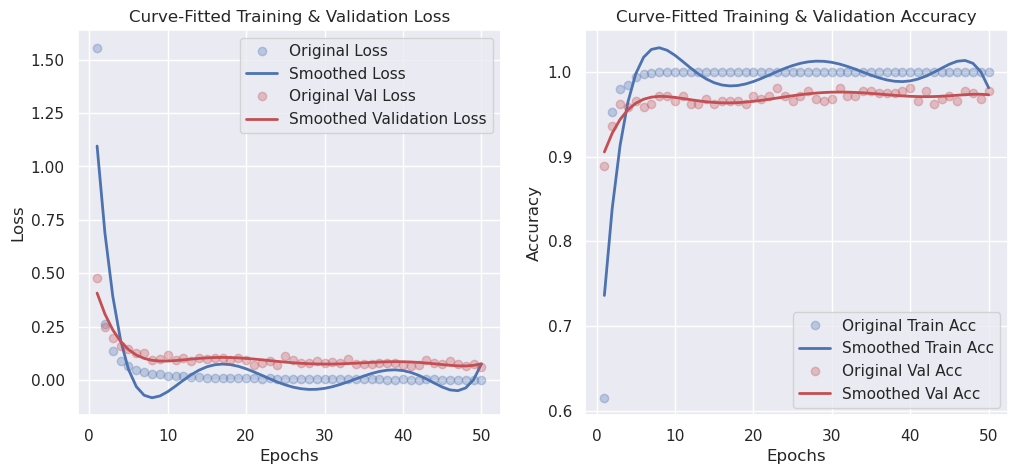

In [27]:
### Loading and Training DeiT (Unfreezing all layers - 1st 9 layers)
### Loading DeiT transformer
# Load model
model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", num_labels = len(classname))

# Freeze first 9 encoder layers
for layer in model.deit.encoder.layer[:9]:
    for param in layer.parameters():
        param.requires_grad = False

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")
        
# Start training the model
loss_module_SGD=nn.CrossEntropyLoss()
optimizer_SGD=torch.optim.SGD(params=model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
num_epochs_SGD=50

# print(f"model DeiT created: {count_parameters(model):05.3f}M")
train_start_SGD = time.time()
model, train_losses_SGD, train_accs_SGD, val_losses_SGD, val_accs_SGD=train_model(model, optimizer_SGD, loss_module_SGD, train_loader, val_loader, num_epochs_SGD, model_name="DeiT_SGD")
train_end_SGD = time.time()

duration_SGD = train_end_SGD-train_start_SGD
minutes_SGD = int(duration_SGD // 60)
seconds_SGD = duration_SGD % 60

if minutes_SGD > 0:
    print(f"Training spent: {minutes_SGD}min {seconds_SGD:.2f}sec")
else:
    print(f"Training spent: {seconds_SGD:.2f}sec")

# evaluate on the test-set
evaluate(model)

if "train_losses_SGD" in globals():
    plot_training_curvefit(train_losses_SGD, val_losses_SGD, train_accs_SGD, val_accs_SGD)

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable: deit.embeddings.cls_token
Trainable: deit.embeddings.distillation_token
Trainable: deit.embeddings.position_embeddings
Trainable: deit.embeddings.patch_embeddings.projection.weight
Trainable: deit.embeddings.patch_embeddings.projection.bias
Trainable: deit.encoder.layer.11.attention.attention.query.weight
Trainable: deit.encoder.layer.11.attention.attention.query.bias
Trainable: deit.encoder.layer.11.attention.attention.key.weight
Trainable: deit.encoder.layer.11.attention.attention.key.bias
Trainable: deit.encoder.layer.11.attention.attention.value.weight
Trainable: deit.encoder.layer.11.attention.attention.value.bias
Trainable: deit.encoder.layer.11.attention.output.dense.weight
Trainable: deit.encoder.layer.11.attention.output.dense.bias
Trainable: deit.encoder.layer.11.intermediate.dense.weight
Trainable: deit.encoder.layer.11.intermediate.dense.bias
Trainable: deit.encoder.layer.11.output.dense.weight
Trainable: deit.encoder.layer.11.output.dense.bias
Trainable: deit.en

Epoch 1/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 1 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  1] Training loss: 1.661, Training accuracy: 60.27%, Validation loss: 0.528, Validation accuracy: 88.89%, Best validation accuracy: 88.89%
--------------------------------------------------


Epoch 2/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 2 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  2] Training loss: 0.325, Training accuracy: 94.97%, Validation loss: 0.271, Validation accuracy: 94.29%, Best validation accuracy: 94.29%
--------------------------------------------------


Epoch 3/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 3 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  3] Training loss: 0.185, Training accuracy: 97.07%, Validation loss: 0.199, Validation accuracy: 94.92%, Best validation accuracy: 94.92%
--------------------------------------------------


Epoch 4/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 4 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  4] Training loss: 0.124, Training accuracy: 98.44%, Validation loss: 0.172, Validation accuracy: 95.56%, Best validation accuracy: 95.56%
--------------------------------------------------


Epoch 5/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 5 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  5] Training loss: 0.098, Training accuracy: 99.32%, Validation loss: 0.137, Validation accuracy: 96.19%, Best validation accuracy: 96.19%
--------------------------------------------------


Epoch 6/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 6 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 7 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 8 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  8] Training loss: 0.053, Training accuracy: 99.39%, Validation loss: 0.110, Validation accuracy: 96.83%, Best validation accuracy: 96.83%
--------------------------------------------------


Epoch 9/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 9 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 10 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 10] Training loss: 0.037, Training accuracy: 100.00%, Validation loss: 0.111, Validation accuracy: 96.51%, Best validation accuracy: 96.83%
--------------------------------------------------


Epoch 11/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 11 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 12 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch 12] Training loss: 0.029, Training accuracy: 99.93%, Validation loss: 0.111, Validation accuracy: 97.46%, Best validation accuracy: 97.46%
--------------------------------------------------


Epoch 13/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 13 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 14 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 15 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 16 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 17 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 18 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 19 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 20 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 20] Training loss: 0.017, Training accuracy: 99.86%, Validation loss: 0.095, Validation accuracy: 96.83%, Best validation accuracy: 97.46%
--------------------------------------------------


Epoch 21/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 21 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch 21] Training loss: 0.015, Training accuracy: 100.00%, Validation loss: 0.080, Validation accuracy: 97.78%, Best validation accuracy: 97.78%
--------------------------------------------------


Epoch 22/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 22 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 23 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 24 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 25 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 26 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 27 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 28 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 29 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 30 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 30] Training loss: 0.009, Training accuracy: 100.00%, Validation loss: 0.101, Validation accuracy: 95.87%, Best validation accuracy: 97.78%
--------------------------------------------------


Epoch 31/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 31 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 32 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 33 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 34 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 35 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 36 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 37 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 38 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 39 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 40 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 40] Training loss: 0.007, Training accuracy: 100.00%, Validation loss: 0.095, Validation accuracy: 95.87%, Best validation accuracy: 97.78%
--------------------------------------------------


Epoch 41/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 41 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 42/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 42 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 43 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 44 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 45 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 46 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 47 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 48 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 49 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch 49] Training loss: 0.006, Training accuracy: 100.00%, Validation loss: 0.088, Validation accuracy: 98.10%, Best validation accuracy: 98.10%
--------------------------------------------------


Epoch 50/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 50 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 50] Training loss: 0.006, Training accuracy: 99.93%, Validation loss: 0.079, Validation accuracy: 97.14%, Best validation accuracy: 98.10%
--------------------------------------------------
Best model loaded from ./checkpoint/ece542_final_proj/DeiT_SGD.pt
Training spent: 7min 12.53sec

=== Final Evaluation on Best Model ===
Accuracy:  0.9651
Precision: 0.9692
Recall:    0.9657
F1-score:  0.9662



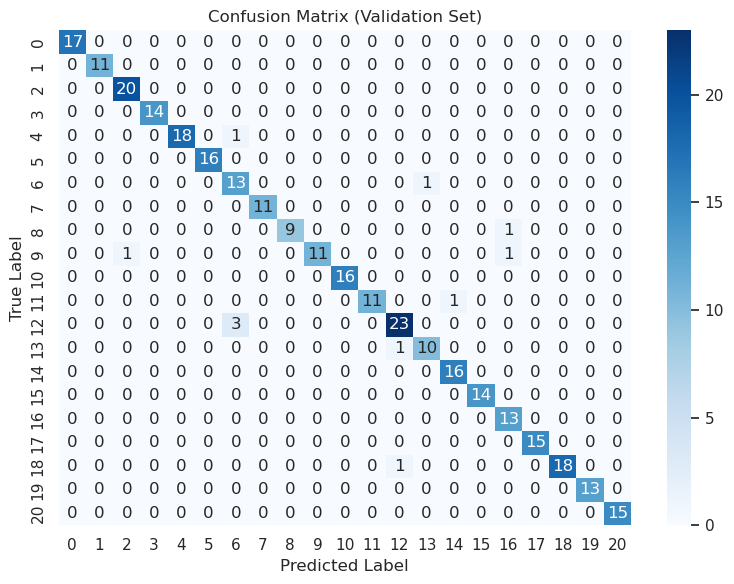

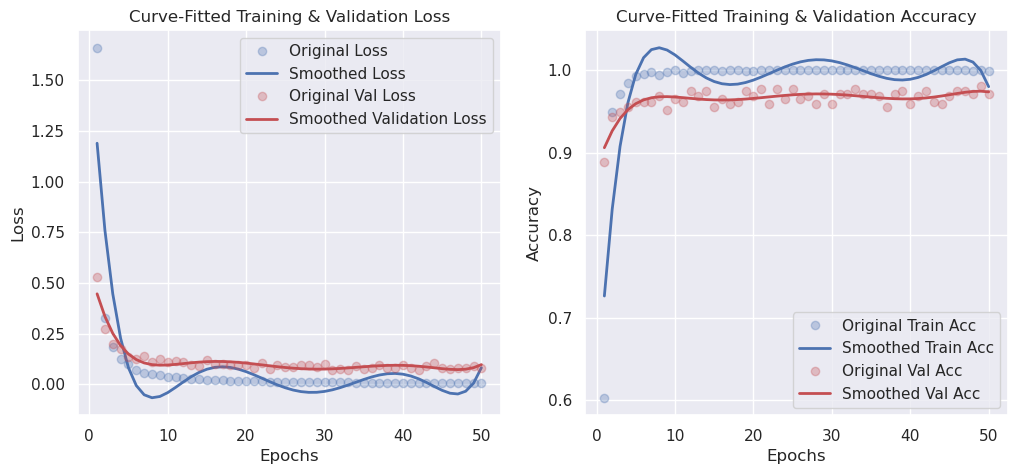

In [29]:
### Loading and Training DeiT (Unfreezing all layers - 1st 11 layers)
### Loading DeiT transformer
# Load model
model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", num_labels = len(classname))

# Freeze first 9 encoder layers
for layer in model.deit.encoder.layer[:11]:
    for param in layer.parameters():
        param.requires_grad = False

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")
        
# Start training the model
loss_module_SGD=nn.CrossEntropyLoss()
optimizer_SGD=torch.optim.SGD(params=model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
num_epochs_SGD=50

# print(f"model DeiT created: {count_parameters(model):05.3f}M")
train_start_SGD = time.time()
model, train_losses_SGD, train_accs_SGD, val_losses_SGD, val_accs_SGD=train_model(model, optimizer_SGD, loss_module_SGD, train_loader, val_loader, num_epochs_SGD, model_name="DeiT_SGD")
train_end_SGD = time.time()

duration_SGD = train_end_SGD-train_start_SGD
minutes_SGD = int(duration_SGD // 60)
seconds_SGD = duration_SGD % 60

if minutes_SGD > 0:
    print(f"Training spent: {minutes_SGD}min {seconds_SGD:.2f}sec")
else:
    print(f"Training spent: {seconds_SGD:.2f}sec")

# evaluate on the test-set
evaluate(model)

if "train_losses_SGD" in globals():
    plot_training_curvefit(train_losses_SGD, val_losses_SGD, train_accs_SGD, val_accs_SGD)

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable: deit.embeddings.cls_token
Trainable: deit.embeddings.distillation_token
Trainable: deit.embeddings.position_embeddings
Trainable: deit.embeddings.patch_embeddings.projection.weight
Trainable: deit.embeddings.patch_embeddings.projection.bias
Trainable: deit.layernorm.weight
Trainable: deit.layernorm.bias
Trainable: classifier.weight
Trainable: classifier.bias


Epoch 1/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 1 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  1] Training loss: 1.811, Training accuracy: 57.07%, Validation loss: 0.707, Validation accuracy: 89.52%, Best validation accuracy: 89.52%
--------------------------------------------------


Epoch 2/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 2 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  2] Training loss: 0.435, Training accuracy: 93.54%, Validation loss: 0.391, Validation accuracy: 91.11%, Best validation accuracy: 91.11%
--------------------------------------------------


Epoch 3/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 3 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  3] Training loss: 0.248, Training accuracy: 96.26%, Validation loss: 0.254, Validation accuracy: 94.60%, Best validation accuracy: 94.60%
--------------------------------------------------


Epoch 4/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 4 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch  4] Training loss: 0.182, Training accuracy: 97.48%, Validation loss: 0.234, Validation accuracy: 96.19%, Best validation accuracy: 96.19%
--------------------------------------------------


Epoch 5/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 5 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 6 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 7 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 8 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 9 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 10 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch 10] Training loss: 0.060, Training accuracy: 99.80%, Validation loss: 0.144, Validation accuracy: 96.51%, Best validation accuracy: 96.51%
--------------------------------------------------


Epoch 11/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 11 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 12 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 13 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 14 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch 14] Training loss: 0.042, Training accuracy: 99.93%, Validation loss: 0.115, Validation accuracy: 96.83%, Best validation accuracy: 96.83%
--------------------------------------------------


Epoch 15/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 15 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 16 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 17 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 18 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 19 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 20 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 20] Training loss: 0.029, Training accuracy: 100.00%, Validation loss: 0.114, Validation accuracy: 96.51%, Best validation accuracy: 96.83%
--------------------------------------------------


Epoch 21/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 21 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 22 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 23 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 24 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 25 :   0%|          | 0/20 [00:00<?, ?it/s]

Best model saved to ./checkpoint/ece542_final_proj/DeiT_SGD.pt
[Epoch 25] Training loss: 0.024, Training accuracy: 99.86%, Validation loss: 0.094, Validation accuracy: 97.78%, Best validation accuracy: 97.78%
--------------------------------------------------


Epoch 26/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 26 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 27 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 28 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 29 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 30 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 30] Training loss: 0.019, Training accuracy: 100.00%, Validation loss: 0.105, Validation accuracy: 96.51%, Best validation accuracy: 97.78%
--------------------------------------------------


Epoch 31/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 31 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 32 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 33 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 34 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 35 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 36 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 37 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 38 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 39 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 40 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 40] Training loss: 0.015, Training accuracy: 100.00%, Validation loss: 0.110, Validation accuracy: 95.87%, Best validation accuracy: 97.78%
--------------------------------------------------


Epoch 41/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 41 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 42/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 42 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 43 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 44 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 45 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 46 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 47 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 48 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 49 :   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50/50 :   0%|          | 0/92 [00:00<?, ?it/s]

Validating Epoch 50 :   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch 50] Training loss: 0.012, Training accuracy: 100.00%, Validation loss: 0.102, Validation accuracy: 97.14%, Best validation accuracy: 97.78%
--------------------------------------------------
Best model loaded from ./checkpoint/ece542_final_proj/DeiT_SGD.pt
Training spent: 6min 56.84sec

=== Final Evaluation on Best Model ===
Accuracy:  0.9556
Precision: 0.9621
Recall:    0.9563
F1-score:  0.9578



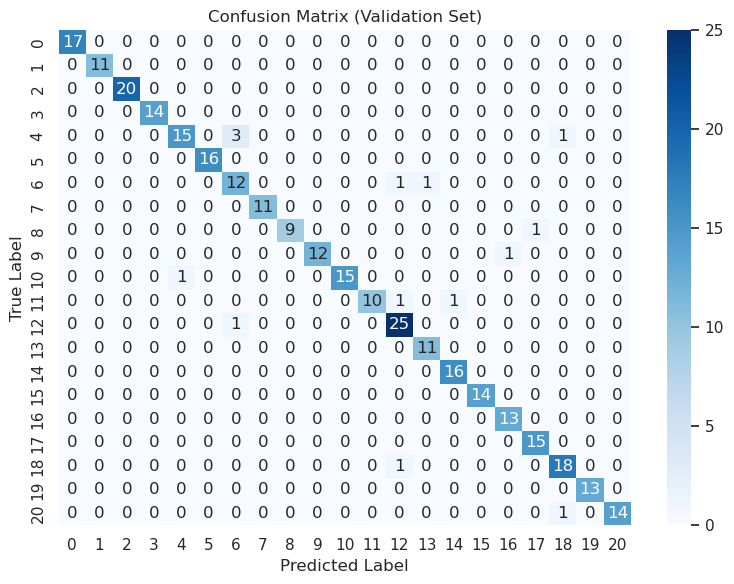

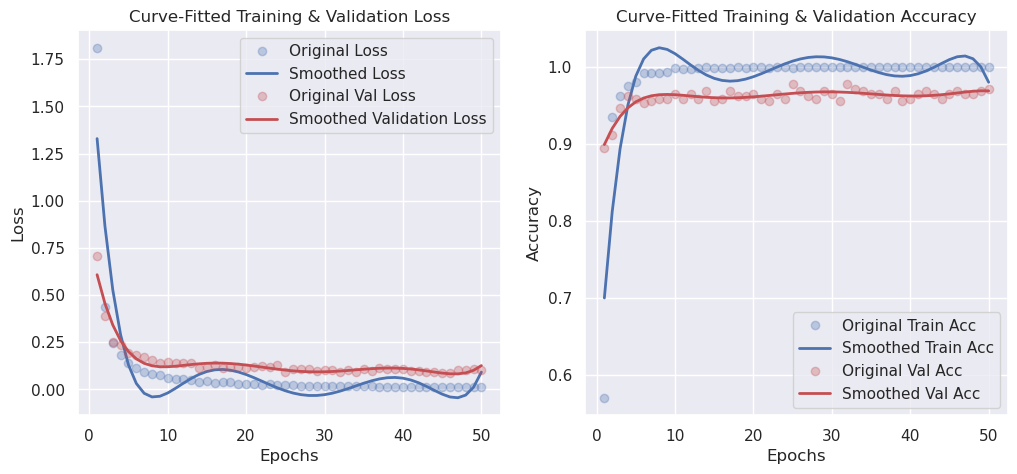

In [28]:
### Loading and Training DeiT (Unfreezing all layers - 1st 12 layers)
### Loading DeiT transformer
# Load model
model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", num_labels = len(classname))

# Freeze first 12 encoder layers
for layer in model.deit.encoder.layer[:12]:
    for param in layer.parameters():
        param.requires_grad = False

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")
        
# Start training the model
loss_module_SGD=nn.CrossEntropyLoss()
optimizer_SGD=torch.optim.SGD(params=model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
num_epochs_SGD=50

# print(f"model DeiT created: {count_parameters(model):05.3f}M")
train_start_SGD = time.time()
model, train_losses_SGD, train_accs_SGD, val_losses_SGD, val_accs_SGD=train_model(model, optimizer_SGD, loss_module_SGD, train_loader, val_loader, num_epochs_SGD, model_name="DeiT_SGD")
train_end_SGD = time.time()

duration_SGD = train_end_SGD-train_start_SGD
minutes_SGD = int(duration_SGD // 60)
seconds_SGD = duration_SGD % 60

if minutes_SGD > 0:
    print(f"Training spent: {minutes_SGD}min {seconds_SGD:.2f}sec")
else:
    print(f"Training spent: {seconds_SGD:.2f}sec")

# evaluate on the test-set
evaluate(model)

if "train_losses_SGD" in globals():
    plot_training_curvefit(train_losses_SGD, val_losses_SGD, train_accs_SGD, val_accs_SGD)

In [32]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", num_labels = len(classname))
# Freeze first 12 encoder layers
for layer in model.deit.encoder.layer[:12]:
    for param in layer.parameters():
        param.requires_grad = False
trainable_params_first12_frozen = count_trainable_parameters(model)
print(f"Trainable parameters first 12 frozen: {trainable_params_first12_frozen:,}")

model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", num_labels = len(classname))
# Freeze first 11 encoder layers
for layer in model.deit.encoder.layer[:11]:
    for param in layer.parameters():
        param.requires_grad = False
trainable_params_first11_frozen = count_trainable_parameters(model)
print(f"Trainable parameters first 11 frozen: {trainable_params_first11_frozen:,}")


model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", num_labels = len(classname))
# Freeze first 9 encoder layers
for layer in model.deit.encoder.layer[:9]:
    for param in layer.parameters():
        param.requires_grad = False
trainable_params_first9_frozen = count_trainable_parameters(model)
print(f"Trainable parameters first 9 frozen: {trainable_params_first9_frozen:,}")

model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", num_labels = len(classname))
# Freeze first 6 encoder layers
for layer in model.deit.encoder.layer[:6]:
    for param in layer.parameters():
        param.requires_grad = False
trainable_params_first6_frozen = count_trainable_parameters(model)
print(f"Trainable parameters first 6 frozen: {trainable_params_first6_frozen:,}")

model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", num_labels = len(classname))
# Freeze first 3 encoder layers
for layer in model.deit.encoder.layer[:3]:
    for param in layer.parameters():
        param.requires_grad = False
trainable_params_first3_frozen = count_trainable_parameters(model)
print(f"Trainable parameters first 3 frozen: {trainable_params_first3_frozen:,}")

model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", num_labels = len(classname))
trainable_params_none_frozen = count_trainable_parameters(model)
print(f"Trainable parameters none frozen: {trainable_params_none_frozen:,}")

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters first 12 frozen: 761,877


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters first 11 frozen: 7,849,749


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters first 9 frozen: 22,025,493


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters first 6 frozen: 43,289,109


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters first 3 frozen: 64,552,725


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters none frozen: 85,816,341


### Reference

[1] UC Merced Land Use Dataset. Available:

https://www.kaggle.com/datasets/abdulhasibuddin/uc-merced-land-use-dataset/data.